In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import sqlite3
con = sqlite3.connect('../summer')
cur = con.cursor()

In [2]:
students = ['\'Alonzo\'','\'Dax\'','\'Emily\'','\'Isabelle\'','\'Jake\'','\'Philip\'','\'Rishab\'','\'Sam\'',
            '\'justin\'','\'Alex\'','\'Jordan\'']
recordings = ['\'week1_3\'', '\'week2_3\'', '\'week3_3\'', '\'week4_3\'', '\'week5_3\'', '\'week6_3\'', '\'week7_3\'', '\'week8_3\'']

all_weeks = pd.read_sql_query("""SELECT PlayerName, RecordingName,
    HeadPos_x, HeadPos_y, HeadPos_z, 
    LeftHandPos_x, LeftHandPos_y, LeftHandPos_z,
    RightHandPos_x, RightHandPos_y, RightHandPos_z,
    HeadRot_x, HeadRot_y, HeadRot_z,
    LeftHandRot_x, LeftHandRot_y, LeftHandRot_z,
    RightHandRot_x, RightHandRot_y, RightHandRot_z
    FROM PersonTime
    WHERE PlayerName IN ({})
    AND RecordingName IN ({})
    """.format(",".join(students), ",".join(recordings)), con)

print(all_weeks.shape)

(4109420, 20)


In [3]:
column_names = ['HeadPos_x', 'HeadPos_y', 'HeadPos_z',
                'LeftHandPos_x', 'LeftHandPos_y', 'LeftHandPos_z',
                'RightHandPos_x', 'RightHandPos_y', 'RightHandPos_z',
                'HeadRot_x', 'HeadRot_y', 'HeadRot_z',
                'LeftHandRot_x', 'LeftHandRot_y', 'LeftHandRot_z',
                'RightHandRot_x', 'RightHandRot_y', 'RightHandRot_z']

playernames = all_weeks['PlayerName'].unique()
recordingnames = all_weeks['RecordingName'].unique()

playerIdx = {
    'Alonzo': 0,
    'Dax': 1,
    'Emily': 2,
    'Isabelle': 3,
    'Jake': 4,
    'Philip': 5,
    'Rishab': 6,
    'Sam': 7,
    'justin': 8,
    'Alex': 9,
    'Jordan': 10
}

X_train = []
y_train = []
X_test = []
y_test = []

for recording_name in recordingnames:
    recording_df = all_weeks[all_weeks['RecordingName'] == recording_name]

    for name in playernames:
        player_df = recording_df[recording_df['PlayerName'] == name]
        
        training_frames = math.ceil(player_df.shape[0] * 0.8)

        for i in range(0, training_frames - 29, 30):
            features = []
            window = player_df.iloc[i:i+29]

            for column_name in column_names:
                column = window[column_name]
                features.extend([column.max(), column.min(), column.median(), column.mean(), column.std()])

            X_train.append(features)
            y_train.append(playerIdx[name])
            
        for i in range(training_frames, player_df.shape[0] - 29, 30):
            features = []
            window = player_df.iloc[i:i+29]

            for column_name in column_names:
                column = window[column_name]
                features.extend([column.max(), column.min(), column.median(), column.mean(), column.std()])

            X_test.append(features)
            y_test.append(playerIdx[name])

print(len(X_train))
print(len(X_train[0]))
print(len(y_train))
print(len(X_test))
print(len(X_test[0]))
print(len(y_test))

109543
90
109543
27355
90
27355


80/20 split per session (dynamically calculated), week1-6 train/week7-8 test

looking for 80 < acc < 95, work on euler angles to compare acc

In [4]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', random_state=42)

In [6]:
y_pred = classifier.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.753683056114056


In [7]:
training_recordings = ['week1_3', 'week2_3', 'week3_3', 'week4_3', 'week5_3', 'week6_3']
testing_recordings = ['week7_3', 'week8_3']

X_train2 = []
y_train2 = []
X_test2 = []
y_test2 = []

for recording_name in training_recordings:
    recording_df = all_weeks[all_weeks['RecordingName'] == recording_name]

    for name in playernames:
        player_df = recording_df[recording_df['PlayerName'] == name]
        
        for i in range(0, player_df.shape[0] - 29, 30):
            features = []
            window = player_df.iloc[i:i+29]

            for column_name in column_names:
                column = window[column_name]
                features.extend([column.max(), column.min(), column.median(), column.mean(), column.std()])

            X_train2.append(features)
            y_train2.append(playerIdx[name])

for recording_name in testing_recordings:
    recording_df = all_weeks[all_weeks['RecordingName'] == recording_name]

    for name in playernames:
        player_df = recording_df[recording_df['PlayerName'] == name]
        
        for i in range(0, player_df.shape[0] - 29, 30):
            features = []
            window = player_df.iloc[i:i+29]

            for column_name in column_names:
                column = window[column_name]
                features.extend([column.max(), column.min(), column.median(), column.mean(), column.std()])

            X_test2.append(features)
            y_test2.append(playerIdx[name])

print(len(X_train2))
print(len(X_train2[0]))
print(len(y_train2))
print(len(X_test2))
print(len(X_test2[0]))
print(len(y_test2))

106304
90
106304
30638
90
30638


In [8]:
scaler2 = StandardScaler()
X_train2 = scaler2.fit_transform(X_train2)
X_test2 = scaler2.transform(X_test2)

In [9]:
classifier2 = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42)
classifier2.fit(X_train2, y_train2)

RandomForestClassifier(criterion='entropy', random_state=42)

In [11]:
y_pred2 = classifier2.predict(X_test2)
print(accuracy_score(y_test2, y_pred2))

0.39764344931131274


In [16]:
df = pd.DataFrame(X_test)
print(df.shape)

random_features = []

for i in range(df.shape[1]):
    random_column = df.copy(deep=True)
    random_column[i] = random_column[i].sample(frac=1).values
    random_column = np.asarray(random_column)
    
    random_features.append(random_column)

for i in range(len(random_features)):
    y_pred3 = classifier.predict(random_features[i])
    print('feature', i, accuracy_score(y_test, y_pred3))

(27355, 90)
feature 0 0.7521111314202157
feature 1 0.7495521842441967
feature 2 0.7510875525498081
feature 3 0.7537196125022848
feature 4 0.753427161396454
feature 5 0.7318588923414366
feature 6 0.7345640650703711
feature 7 0.7353317492231768
feature 8 0.7356242003290075
feature 9 0.7537196125022848
feature 10 0.7493694023030525
feature 11 0.7497349661853409
feature 12 0.7516724547614696
feature 13 0.7522208005849023
feature 14 0.7535368305611405
feature 15 0.7517821239261561
feature 16 0.7552549808078962
feature 17 0.7524035825260464
feature 18 0.7524766953025042
feature 19 0.7535002741729118
feature 20 0.7516724547614696
feature 21 0.7447632973862183
feature 22 0.747139462621093
feature 23 0.7512337781027234
feature 24 0.7533174922317675
feature 25 0.7531712666788521
feature 26 0.7529153719612502
feature 27 0.7527691464083348
feature 28 0.7560592213489308
feature 29 0.7539755072198867
feature 30 0.7511972217144947
feature 31 0.750429537561689
feature 32 0.7533174922317675
feature 33 

In [17]:
df = pd.DataFrame(X_test2)
print(df.shape)

random_features = []

for i in range(df.shape[1]):
    random_column = df.copy(deep=True)
    random_column[i] = random_column[i].sample(frac=1).values
    random_column = np.asarray(random_column)
    
    random_features.append(random_column)

for i in range(len(random_features)):
    y_pred = classifier2.predict(random_features[i])
    print('feature', i, accuracy_score(y_test2, y_pred))

(30638, 90)
feature 0 0.3997649977152556
feature 1 0.3975128924864547
feature 2 0.40257196944970297
feature 3 0.39842679026046085
feature 4 0.3973170572491677
feature 5 0.3920947842548469
feature 6 0.3914420001305568
feature 7 0.3894836477576865
feature 8 0.389124616489327
feature 9 0.39774136692995626
feature 10 0.39757817089888375
feature 11 0.4000587505711861
feature 12 0.39956916247796853
feature 13 0.4007441739016907
feature 14 0.39708858280566617
feature 15 0.4006136170768327
feature 16 0.39888373914746394
feature 17 0.40084209152033423
feature 18 0.40018930739604414
feature 19 0.3979372021672433
feature 20 0.39362882694692863
feature 21 0.39033226711926367
feature 22 0.3919642274299889
feature 23 0.3914420001305568
feature 24 0.3973496964553822
feature 25 0.3974149748678112
feature 26 0.4013969580259808
feature 27 0.3988184607350349
feature 28 0.39914485279718
feature 29 0.39650107709380505
feature 30 0.4014295972321953
feature 31 0.3978719237548143
feature 32 0.4011358443762647

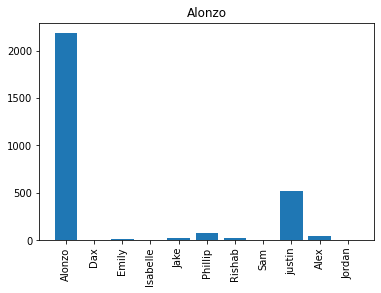

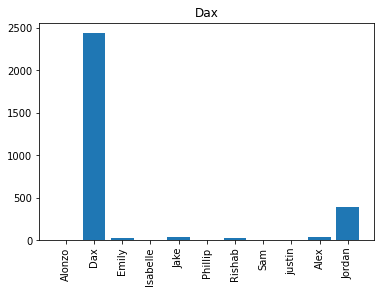

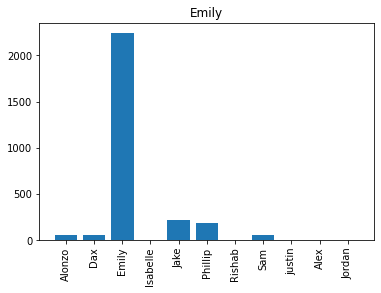

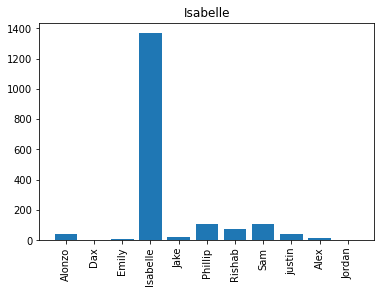

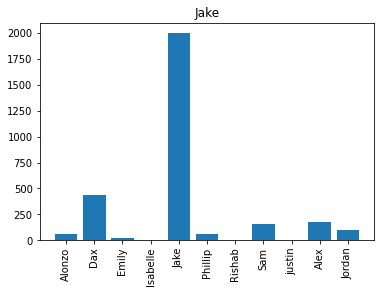

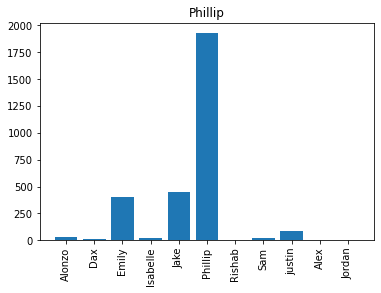

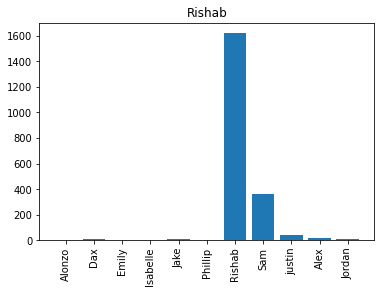

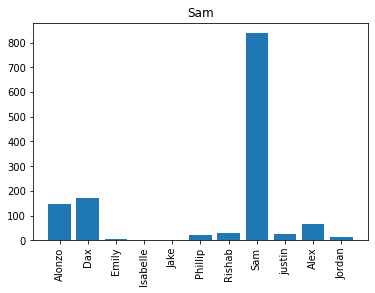

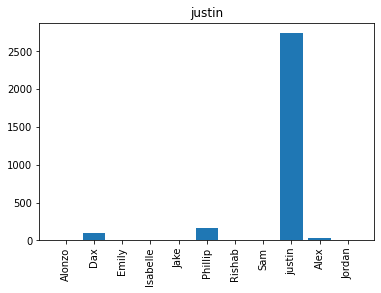

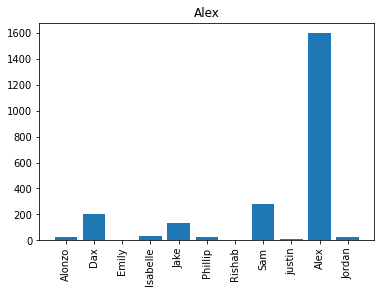

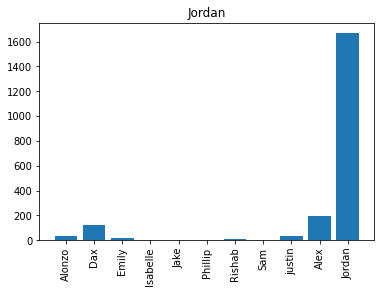

In [26]:
import matplotlib.pyplot as plt

students = ['Alonzo', 'Dax', 'Emily', 'Isabelle', 'Jake', 'Phillip', 'Rishab', 'Sam', 'justin', 'Alex', 'Jordan']

test_labels = [[0 for _ in range(11)] for _ in range(11)]

for i in range(len(X_test)):
    prediction = classifier.predict([X_test[i]])[0]
    truth = y_test[i]
    test_labels[truth][prediction] += 1

for i in range(11):
    plt.bar(students, test_labels[i])
    plt.xticks(rotation=90)
    plt.title(students[i])
    plt.show()

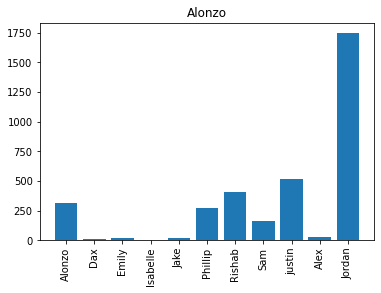

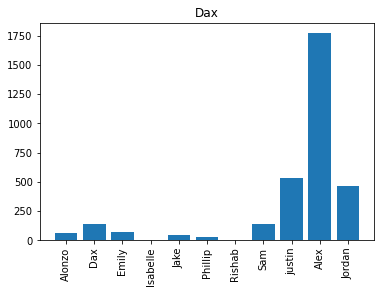

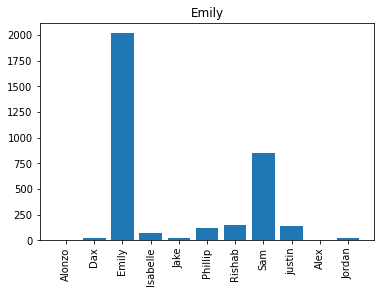

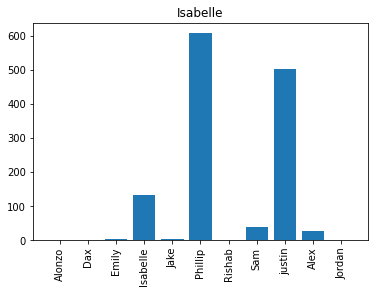

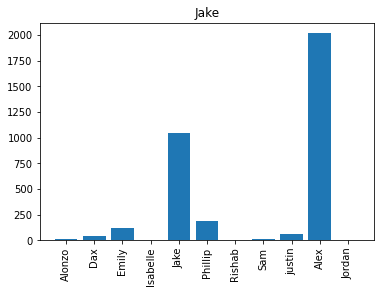

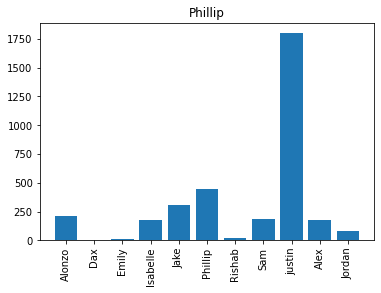

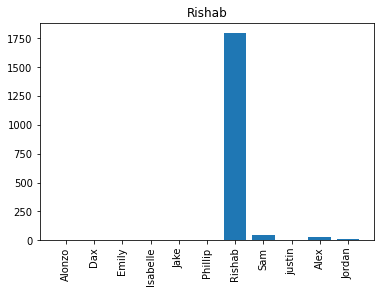

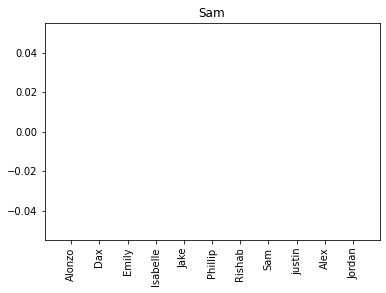

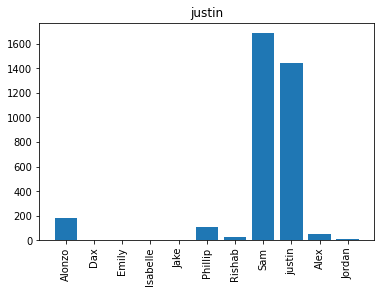

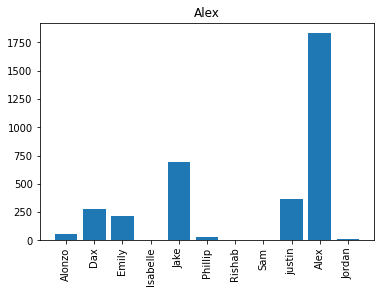

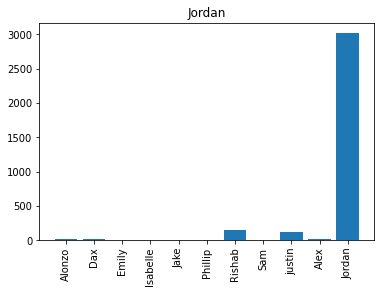

In [28]:
test_labels2 = [[0 for _ in range(11)] for _ in range(11)]

for i in range(len(X_test2)):
    prediction = classifier2.predict([X_test2[i]])[0]
    truth = y_test2[i]
    test_labels2[truth][prediction] += 1

for i in range(11):
    plt.bar(students, test_labels2[i])
    plt.xticks(rotation=90)
    plt.title(students[i])
    plt.show()